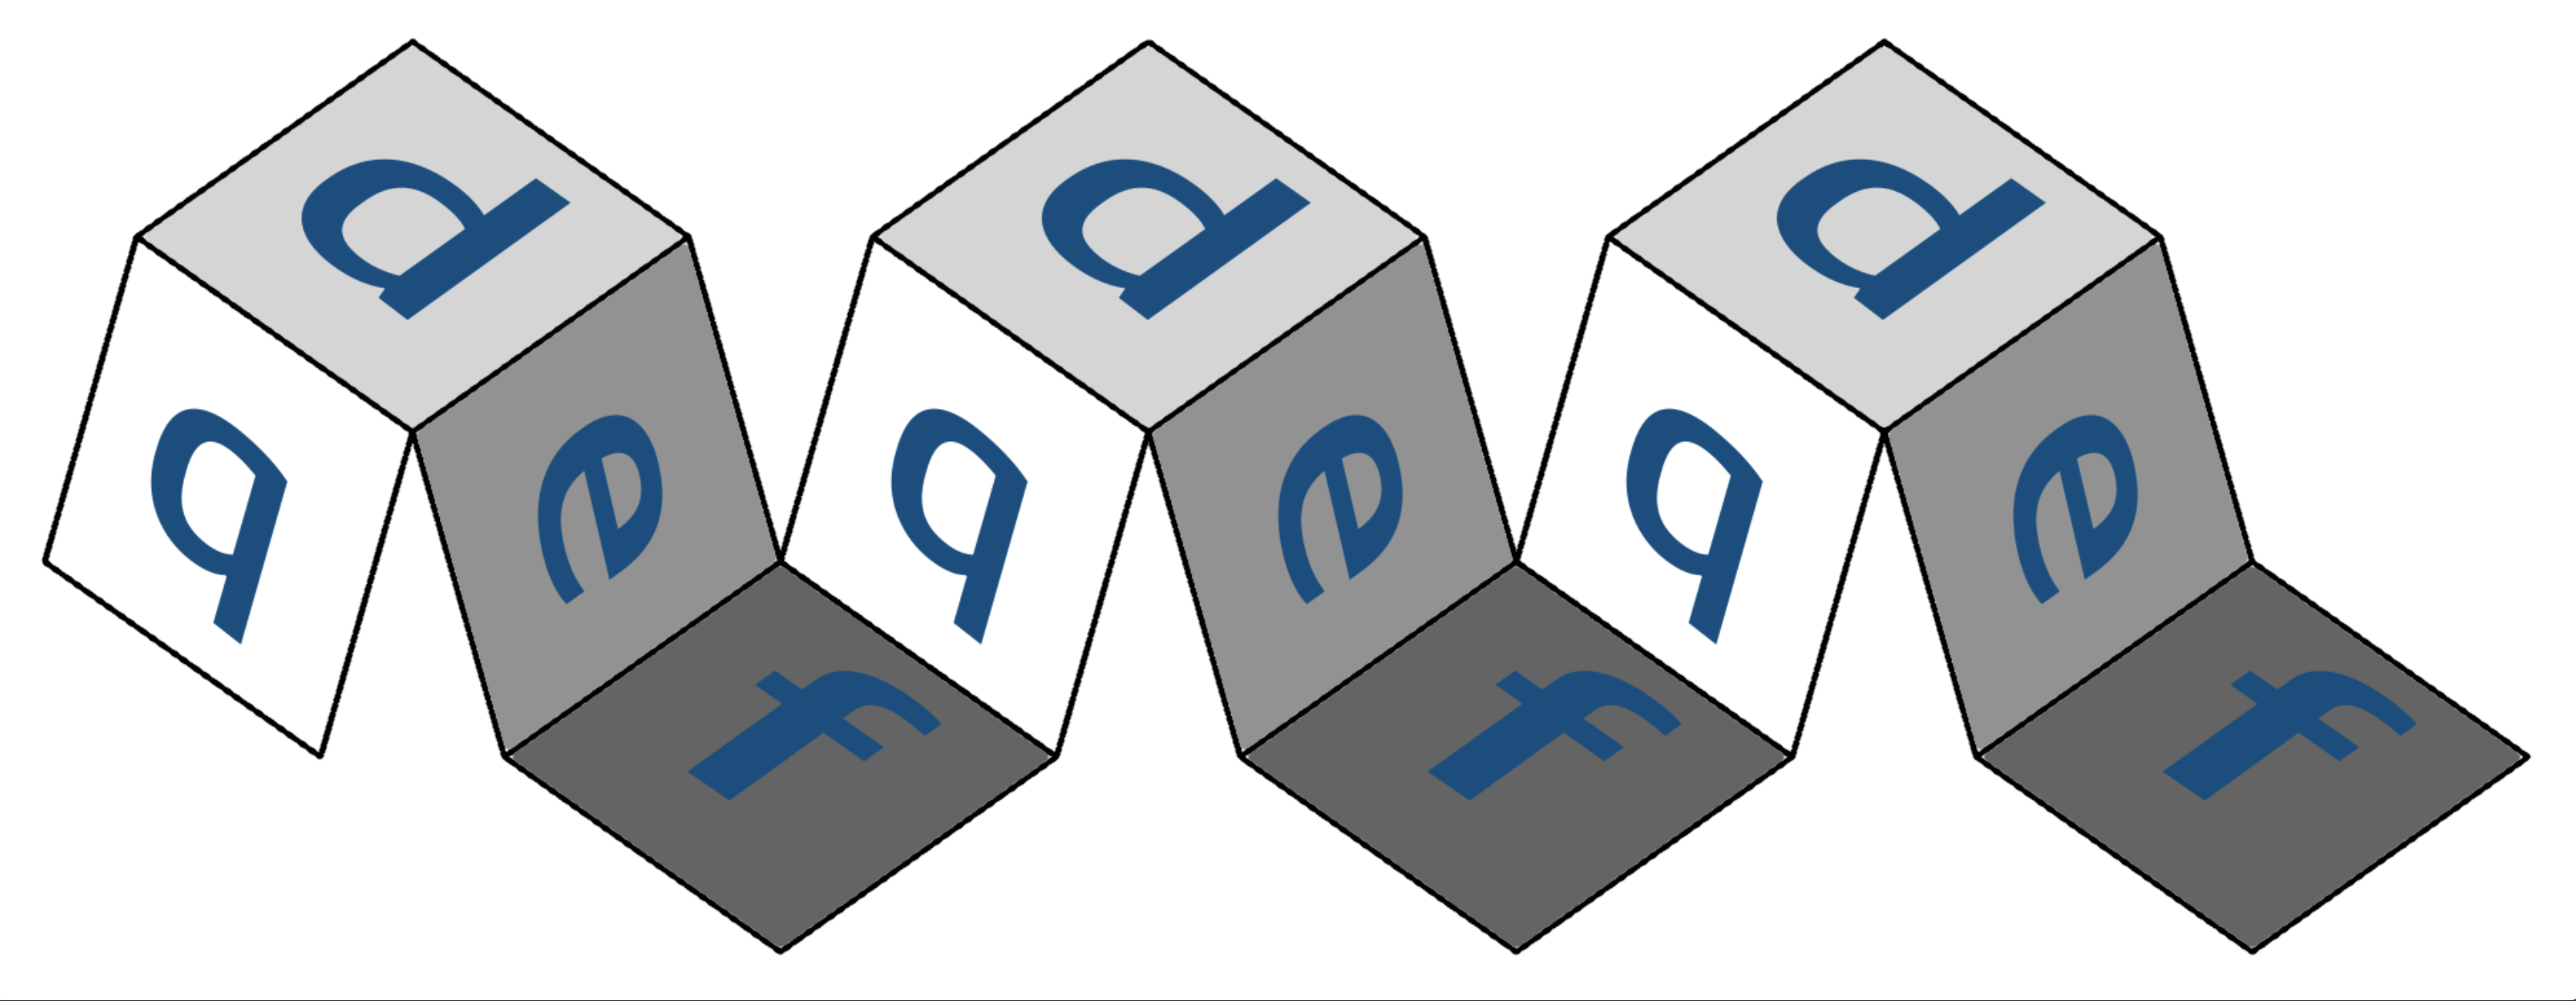

Parsing data into qdef.

Mathematica notebook which generates the raw data is `qdef_gtpack.nb`

Data for each group is parsed into a dictionary with the following keys:

- `index`: int [1-32]
- `notation`: str Mulliken or Bethe
- `group label`: str eg. "C_{3v}"
- `irrep labels`: list of sympy.Symbol
- `class labels`: list of sympy.Symbol
- `irrep matrices`: dict {k(sympy.Symbol) : v(sympy.Matrix) }
- `classes`: dict  {k(class - sympy.Symbol) : v(group-ops list[sympy.Symbol])}
- `generators`: list of sympy.Symbol with set of generators
- `character table`: sympy.Matrix, each row corresponds to an irrep
- `multiplication table`: sympy.Matrix, left factor in product determined by row
- `euler angles`: dict { k(group_op - sympy.Symbol) : v([α, β, γ, det]) }
- `group operations`: list of sympy.Symbol

In addition, a set of metadata is also created here. It is saved as a dictionary with the following keys:

- `Mulliken notation` : dictionary that specifies the letters used in Mulliken notation
- `Euler angles` : explanation of convention used for Euler angles
- `Rotation axes` : dict {k(axis label): [x,y,z]}

In [4]:
import sympy as sp
from sympy import I
from sympy.parsing.latex import parse_latex
import re
import pickle

In [11]:
mulliken_notation = {'A': 'singly degenerate rep; symmetrical for rotations about the principal axis',
                    'B': 'singly degenerate rep; anti-symmetrical for rotations about the principal axis',
                    'E': 'either doubly degenerate rep, or one of a pair of singly degenerate conjugate reps',
                    'T': 'triply degenerate rep',
                    'F': 'fourfold degenerate rep, or one of a pair of doubly degenerate conjugate reps',
                    'H': 'fivevold degenerate rep'}
mulliken_or_bethe_notation = 'In all groups Mulliken notation is used, except groups 11 and 23 where Bethe notation is used instead.'
rotation_axes = {
                'a': [1,1,0],
                'b': [1,-1,0],
                'c': [1,0,1],
                'd': [-1,0,1],
                'e': [0,1,1],
                'f': [0,1,-1],
                'γ': [1,-1,-1],
                'β': [-1,1,-1],
                'α': [-1,-1,1],
                'δ': [1,1,1],
                'x': [1,0,0],
                'y': [0,1,0],
                'z': [0,0,1],
                'A': [-sp.sqrt(3)/3,-1,0],
                'B': [-sp.sqrt(3)/3,1,0],
                'C': [sp.sqrt(3),-1,0],
                'D': [sp.sqrt(3),1,0]
                }
rotation_axes = {k: (sp.Matrix(v)/sp.Matrix(v).norm()).T.tolist()[0] for k, v in rotation_axes.items()}
euler_angles_note = '''First three elements are the angles, last element is the determinant of the rotation.
                    Active rotations are assumed.
                    first angle -> α: final rotation about the fixed z-axis
                    sencond angle -> β: intermediate rotation about the fixed y-axis
                    third angle -> γ: initial rotation about the fixed z-axis,
                    corresponding rotation matrix is:
                    [[-sin(α)*sin(γ) + cos(α)*cos(β)*cos(γ),-sin(α)*cos(γ) - sin(γ)*cos(α)*cos(β),sin(β)*cos(α)],
                    [sin(α)*cos(β)*cos(γ) + sin(γ)*cos(α),-sin(α)*sin(γ)*cos(β) + cos(α)*cos(γ),sin(α)*sin(β)],
                    [-sin(β)*cos(γ),sin(β)*sin(γ),cos(β)]]'''
metadata = {'Mulliken notation': mulliken_notation,
            'Euler angles': euler_angles_note,
            'Rotation axes': rotation_axes}

In [12]:
def parse_group_data(group_index):
    '''
    Parse the output from GTPack v 1.32, as produced in qdef.nb.
    For groups [1,30] irreducible representations were generated
    with the Cornwell method, and for  groups [31,32]  with  the
    Induction method. 
    '''
    def symbolize(symb):
        return sp.Symbol(re.sub('{(.)}',r'\1', symb))
    def simplify_pies(expr):
        return expr.subs(sp.Symbol("pi"),sp.pi)
    notation = 'Mulliken'
    if group_index in [11,23]:
        notation = 'Bethe'
    fname = '/Users/juan/Google Drive/Zia Lab/Codebase/qdef/Group Data/Group_%d.txt' % group_index
    group_string = open(fname,'r').read()
    
    group_lines = group_string.split('\n')
    
    # line 0 has the index and the name of the group
    group_label = group_lines[0].split(',')[1]
    if len(group_label) > 1:
        group_label = '%s_{%s}' % (group_label[0],group_label[1:])
    group_index = int(group_lines[0].split(',')[0])
    
    # line 1 has the labels for the irreducible representations
    irrep_labels = group_lines[1].split(',')
    irrep_labels = list(map(symbolize,irrep_labels))
    
    # line 2 has the dimensions of the irreducible representations
    irrep_dims = list(map(int,group_lines[2].split(',')))
    
    # line 3 has the sizes of the conjugacy classes
    class_dims = list(map(int,group_lines[3].split(',')))
    
    # line 4 has the elements of classes
    class_elements_flat = list(map(symbolize, group_lines[4].split(',')))
    num_elements = len(class_elements_flat)
    
    # line 5 has the labels for the classes
    class_labels = list(map(symbolize, group_lines[5].split(',')))
    num_classes = len(class_labels)
    # parse the classes as a dictionary
    post = 0
    classes = {}
    for class_label, class_dim in zip(class_labels,class_dims):
        classes[class_label] = class_elements_flat[post:post+class_dim]
        post = class_dim
    
    # line 6 has the labels for the group elements in an ordering matching the irreducible rep matrices ordering
    group_op_labels = list(map(symbolize, group_lines[6].split(',')))
    
    # line 7 has the labels for a set of generators
    generators = group_lines[7].split(',')
    generators = list(map(symbolize,generators))
    
    # line 8 has the euler angles for all the group operations
    eulerangles_raw = list(map(parse_latex, group_lines[8].split(',')))
    eulerangles = {}
    for idx, group_op_label in enumerate(group_op_labels):
        eulerangles[group_op_label] = list(map(simplify_pies,eulerangles_raw[4*idx:4*(idx+1)]))
    
    # line 9 has the character table
    char_table = list(map(lambda x: parse_latex(x).subs(sp.Symbol('i'),I), group_lines[9].split(',')))
    char_table = sp.Matrix(char_table).reshape(num_classes,num_classes)
    
    # line 10 has the multiplication table
    mult_table = group_lines[10].split(',')
    mult_table = sp.Matrix(list(map(symbolize,mult_table))).reshape(num_elements,num_elements)
    
    # remaining lines have matrices for irreducible reps
    irrep_matrices = {}
    for group_line, irrep_dim, irrep_label in zip(group_lines[11:], irrep_dims, irrep_labels):
        if 'i' in group_line:
            elements = list(map(lambda x: parse_latex(x).subs(sp.Symbol('i'),I),group_line.split(',')))
        else:
            elements = list(map(parse_latex,group_line.split(',')))
        # partition this list into chunks of size irrep_dim^2
        chunk_size = irrep_dim**2
        flat_irrep_matrices = [elements[chunk_size*i:chunk_size*(i+1)] for i in range(num_elements)]
        # reshape them and save them as values to a dictionary
        some_irrep_matrices = {}
        for element_label, flat_matrix in zip(group_op_labels, flat_irrep_matrices):
            matri = sp.Matrix(flat_matrix).T
            some_irrep_matrices[element_label] = matri.reshape(irrep_dim,irrep_dim)
        irrep_matrices[irrep_label] = some_irrep_matrices
    
    return {'index': group_index,
           'notation': notation,
           'group label': group_label,
           'irrep labels': irrep_labels,
           'class labels': class_labels,
           'irrep matrices': irrep_matrices,
           'classes': classes,
           'generators': generators,
           'class labels': class_labels,
           'character table': char_table,
           'multiplication table': mult_table,
           'euler angles': eulerangles,
           'group operations': group_op_labels}

In [327]:
group_data = {i: parse_group_data(i) for i in range(1,33)}

In [17]:
for group in group_data:
    print("'%s'," % group_data[group]['group label'])

'C_{1}',
'C_{i}',
'C_{2}',
'C_{s}',
'C_{2h}',
'D_{2}',
'C_{2v}',
'D_{2h}',
'C_{4}',
'S_{4}',
'C_{4h}',
'D_{4}',
'C_{4v}',
'D_{2d}',
'D_{4h}',
'C_{3}',
'S_{6}',
'D_{3}',
'C_{3v}',
'D_{3d}',
'C_{6}',
'C_{3h}',
'C_{6h}',
'D_{6}',
'C_{6v}',
'D_{3h}',
'D_{6h}',
'T',
'T_{h}',
'O',
'T_{d}',
'O_{h}',


In [15]:
# pickle.dump({'metadata': metadata,
#              'group_data': group_data},
#            open('/Users/juan/Google Drive/Zia Lab/Codebase/qdef/data/gtpackdata.pkl',
#                'wb'))

In [3]:
import pickle

In [5]:
!open .

In [8]:
big_pickle = pickle.load(open('./data/gtpackdata.pkl','rb'))

In [9]:
big_pickle.keys()

dict_keys(['metadata', 'group_data'])

In [12]:
(big_pickle['group_data']).keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

In [30]:
big_pickle['group_data'][30].keys()

dict_keys(['index', 'notation', 'group label', 'irrep labels', 'class labels', 'irrep matrices', 'classes', 'generators', 'character table', 'multiplication table', 'euler angles', 'group operations'])

In [328]:
class CrystalGroup():
    """Class for group character tables"""
    def __init__(self, group_data_dict):
        self.index = group_data_dict['index']
        self.label = group_data_dict['group label']
        self.classes = group_data_dict['classes']
        self.irrep_labels = group_data_dict['irrep labels']
        self.char_table = group_data_dict['character table']
        self.char_table_inverse = sp.simplify(group_data_dict['character table'].T**(-1))

In [329]:
class Qet():
  '''
  A Qet is a dictionary of keys and values. Keys
  correspond to tuples of quantum numbers or symbols
  and the values correspond to the accompanying
  coefficients.
  Scalars may be added by  using  an  empty tuple
  as a key.
  A qet may be multiplied by a scalar,  in  which
  case all the coefficients are multiplied by it,
  It  may  also  be  multiplied by  another  qet,
  in which case quantum numbers are  concatenated
  and coefficients multiplied accordingly.

  '''
  def __init__(self, bits=0):
    if bits == 0:
        self.dict = {}
    elif isinstance(bits, dict):
        self.dict = {k: v for k, v in bits.items() if v!=0}

  def __add__(self, other):
    new_dict = dict(self.dict)
    if other == 0:
        return self
    for key, coeff in other.dict.items():
      if key in new_dict.keys():
        new_dict[key] += coeff
      else:
        new_dict[key] = coeff
    return Qet(new_dict)

  def vec_in_basis(self, basis):
    '''given an ordered basis  return   a
    list with the coefficients of the qet
    in that basis'''
    coeffs = [0]*len(basis)
    for key, val in self.dict.items():
      coeffs[basis.index(key)] = val
    return coeffs

  def subs(self, subs_dict):
    new_dict = dict()
    for key, val in self.dict.items():
      new_dict[key] = S(val).subs(subs_dict)
    return Qet(new_dict)

  def __mul__(self, multiplier):
    '''if multiplier is another
    qet, then concatenate the dict and
    multiply coefficients, if multiplier is
    something else then try to multiply
    the qet coefficients by the given multiplier'''
    if isinstance(multiplier, Qet):
      new_dict = dict()
      for k1, v1 in self.dict.items():
        for k2, v2 in multiplier.dict.items():
          k3 = k1 + k2
          v3 = v1 * v2
          if v3 !=0:
            new_dict[k3] = v3
      return Qet(new_dict)
    else:
      new_dict = dict(self.dict)
      for key, coeff in new_dict.items():
        new_dict[key] = multiplier*(coeff)
      return Qet(new_dict)

  def __rmul__(self, multiplier):
    '''this is required to enable multiplication
    from the left and from the right'''
    new_dict = dict()
    for key, coeff in self.dict.items():
      new_dict[key] = multiplier*(coeff)
    return Qet(new_dict)

  def basis(self):
    '''return a list with all the keys in the qet'''
    return list(self.dict.keys())

  def dual(self):
    '''conjugate all the coefficients'''
    new_dict = dict(self.dict)
    for key, coeff in new_dict.items():
      new_dict[key] = conjugate(coeff)
    return Qet(new_dict)

  def as_operator(self, opfun):
    OP = S(0)
    for key, val in self.dict.items():
        OP += S(val) * opfun(*key)
    return OP

  def as_ket(self, fold_keys=False, nice_negatives=False):
    '''give a representation of the qet
    as a Ket from sympy.physics.quantum
    fold_keys = True removes unnecessary parentheses
    and nice_negatives = True assumes all numeric keys
    and presents negative values with a bar on top'''
    sympyRep = S(0)
    for key, coeff in self.dict.items():
      if key == ():
        sympyRep += coeff
      else:
        if fold_keys:
          if nice_negatives:
            key = tuple(latex(k) if k>=0 else (r'\bar{%s}' % latex(-k)) for k in key)
          sympyRep += coeff*Ket(*key)
        else:
          sympyRep += coeff*Ket(key)
    return sympyRep


  def as_bra(self):
    '''give a representation of the qet
    as a Bra from sympy.physics.quantum'''
    sympyRep = S(0)
    for key, coeff in self.dict.items():
      if key == ():
        sympyRep += coeff
      else:
        sympyRep += coeff*Bra(*key)
    return sympyRep

  def as_braket(self):
    '''give a representation of the qet
    as a Bra*Ket the dict of the qet are
    assumed to split half for the bra, and
    other half for the ket.'''
    sympyRep = S(0)
    for key, coeff in self.dict.items():
      l = int(len(key)/2)
      if key == ():
        sympyRep += coeff
      else:
        sympyRep += coeff*(Bra(*key[:l])*Ket(*key[l:]))
    return sympyRep

  def as_symbol_sum(self):
    tot = sp.S(0)
    for k, v in self.dict.items():
      tot += v*k
    return tot

  def as_c_number_with_fun(self):
    '''the coefficients of a qet can be tuples
    and if the first element is a function then
    this method can be used to apply that function
    to the dict and multiply that result by the
    coefficient, which is assumed to be the second
    element of the tuple'''
    sympyRep = S(0)
    for key, op_and_coeff in self.dict.items():
      ops_and_coeffs = list(zip(op_and_coeff[::2],op_and_coeff[1::2]))
      for op, coeff in ops_and_coeffs:
        if key == ():
          sympyRep += coeff
        else:
          sympyRep += coeff*op(*key)#Function(op)(*key)
    return sympyRep

  def apply(self,f):
    '''this method can be used to apply a function to a qet
    the provided function f must take as arguments a single
    pair of qnum and coeff and return a dictionary or a
    (qnum, coeff) tuple'''
    new_dict = dict()
    for key, coeff in self.dict.items():
      appfun = f(key,coeff)
      if isinstance(appfun, dict):
        for key2, coeff2 in appfun.items():
          if coeff2 != 0:
            if key2 not in new_dict.keys():
              new_dict[key2] = coeff2
            else:
              new_dict[key2] += coeff2
      else:
        new_key, new_coeff = appfun
        if new_coeff !=0:
          if new_key not in new_dict.keys():
            new_dict[new_key] = (new_coeff)
          else:
            new_dict[new_key] += (new_coeff)
    return Qet(new_dict)

  def norm(self):
    '''compute the norm of the qet'''
    norm2 = 0
    for key, coeff in self.dict.items():
      norm2 += abs(coeff)**2
    return sqrt(norm2)

  def symmetrize(self):
    '''at times a tuple of dict needs to
    be identified with its inverse'''
    new_dict = dict()
    for key, coeff in self.dict.items():
      rkey = key[::-1]
      if rkey in new_dict.keys():
        new_dict[rkey] += coeff
      else:
        if key in new_dict.keys():
          new_dict[key] += coeff
        else:
          new_dict[key] = coeff
    return Qet(new_dict)

  def __repr__(self):
    return str(self.dict)

In [379]:
class ProductTable():
    def __init__(self, odict, irrep_labels, grp_label):
        self.odict = odict
        self.irrep_labels = irrep_labels
        self.grp_label = grp_label
    def pretty_parse(self):
        '''creates a nice latex representation of the product table'''
        irep_symbols = self.irrep_labels
        list_o_lists = [[self.odict[(ir0,ir1)] for ir0 in self.irrep_labels] for ir1 in self.irrep_labels]
        rows = [[self.grp_label]+irep_symbols]
        for idx, arow in enumerate(list_o_lists):
            row = [irep_symbols[idx]]
            row.extend(arow)
            rows.append(row)
        return fmt_table(rows).replace('+',r'{\oplus}')  

In [380]:
def fmt_table(data, center_data=False, add_row_nums=False):
    '''Create a LaTeX table from a given list of lists'''
    buf='''
\\newcommand\\T{\\Rule{0pt}{1em}{.3em}}
\\begin{array}{%s}
'''
    max_cols = max(len(r) for r in data)
    column_spec = '|' + '|'.join(['c']*max_cols) + '|'
    buf = buf % column_spec
    row_idx = 0
    for row_data in data:
        row = ''
        if add_row_nums and row_idx > 0:
            row += str(row_idx) + " & "
        if center_data and row_idx > 0:
            to_add = math.ceil( (max_cols - len(row_data))/2 )
            row += ' & '.join([''] * to_add)
        row += ' & '.join([sp.latex(thing) for thing in row_data])
        if row_idx == 0:
            row = '''\\hline ''' + row + '''\\\\\hline '''
        else:
            row += '''\\\\\hline '''
        row += "\n"
        buf +=row
        row_idx += 1
    buf += '''\\end{array}'''
    return buf

In [381]:
class CPGroups():
    """Class of all crystallographic point groups"""
    def __init__(self, groups):
        self.all_group_labels = [
            'C_{1}', 'C_{i}', 'C_{2}', 'C_{s}',
            'C_{2h}', 'D_{2}', 'C_{2v}', 'D_{2h}',
            'C_{4}', 'S_{4}', 'C_{4h}', 'D_{4}',
            'C_{4v}', 'D_{2d}', 'D_{4h}', 'C_{3}',
            'S_{6}', 'D_{3}', 'C_{3v}', 'D_{3d}',
            'C_{6}', 'C_{3h}', 'C_{6h}', 'D_{6}',
            'C_{6v}', 'D_{3h}', 'D_{6h}', 'T',
            'T_{h}', 'O', 'T_{d}', 'O_{h}']
        self.groups = {k: CrystalGroup(v) for k, v in groups.items()}
    def direct_product(self,group_label, ir0, ir1):
        '''
        Given the label for a cpg and labels for two
        of its irreducible representations, determine
        the direct sum decomposition of their product.
        This product is returned as a qet with keys
        corresponding to the irreps and values equal
        to the integer coefficients
        '''
        # grab group classes, irrep names, and character table
        group = self.groups[1+self.all_group_labels.index(group_label)]
        group_classes = group.classes
        group_irreps = group.irrep_labels
        group_chartable = group.char_table
        assert ir0 in group_irreps, 'irrep not in %s' % str(group_irreps)
        assert ir1 in group_irreps, 'irrep not in %s' % str(group_irreps)
        chars_0, chars_1 = [group_chartable.row(group_irreps.index(ir)) for ir in [ir0, ir1]]
        chars = sp.Matrix([char0*char1 for char0, char1 in zip(chars_0, chars_1)])
        partition = (group.char_table_inverse*chars)
        qet = Qet()
        for element, ir in zip(partition, group_irreps):
            el = int(sp.N(element,1,chop=True))
            qet = qet + Qet({ir:el})
        return qet.as_symbol_sum()
    def direct_product_table(self, group_label):
        '''
        This creates the complete set of  binary
        products of irreducible representations.
        The result is saved as  an attribute  in
        the group.
        '''
        group = self.groups[1+self.all_group_labels.index(group_label)]
        if hasattr(group, 'product_table'):
            return group.product_table
        group_classes = group.classes
        group_irreps = group.irrep_labels
        product_table = OrderedDict()
        for ir0 in group_irreps:
            for ir1 in group_irreps:
                if (ir1,ir0) in product_table.keys():
                    product_table[(ir0,ir1)] = product_table[(ir1,ir0)]
                else:
                    product_table[(ir0,ir1)] = self.direct_product(group_label, ir0, ir1)#.as_symbol_sum()
        group.product_table = ProductTable(product_table, group_irreps, group_label)
        return group.product_table

In [382]:
CPGs = CPGroups({i: group_data[i] for i in [30,31]})

In [383]:
CPGs.groups[30].irrep_labels

[A_1, A_2, E, T_1, T_2]

In [384]:
CPGs.direct_product('O',sp.Symbol('T_2'),sp.Symbol('T_2'))

A_1 + E + T_1 + T_2

In [385]:
CPGs.direct_product_table('O')

In [376]:
from collections import OrderedDict

In [377]:
from IPython.display import display, HTML, Math

In [378]:
Math(CPGs.groups[30].product_table.pretty_parse())

<IPython.core.display.Math object>

In [198]:
Math(CPGs.groups[30].product_table.pretty_parse())

TypeError: Math expects text, not [['A_{1}', 'A_{2}', 'E', 'T_{1}', 'T_{2}'], [A_1, 'A', '_', '{', '1', '}'], [A_2, 'A', '_', '{', '2', '}'], [E, 'E'], [T_1, 'T', '_', '{', '1', '}'], [T_2, 'T', '_', '{', '2', '}']]

In [136]:
display(Math(sp.latex(CPGs.groups[30].char_table)))

<IPython.core.display.Math object>

In [57]:
@classmethod

CPGroups.direct_product = direct_product

In [47]:
CPGs.groups[1].char_table_inverse

Matrix([[1]])

In [38]:
CPGs.groups

{1: {'index': 1,
  'notation': 'Mulliken',
  'group label': 'C_{1}',
  'irrep labels': [A],
  'class labels': [1{Ee}],
  'irrep matrices': {A: {{Ee}: Matrix([[1]])}},
  'classes': {1{Ee}: [{Ee}]},
  'generators': [{Ee}],
  'character table': Matrix([[1]]),
  'multiplication table': Matrix([[{Ee}]]),
  'euler angles': {{Ee}: [0, 0, 0, 1]},
  'group operations': [{Ee}]},
 2: {'index': 2,
  'notation': 'Mulliken',
  'group label': 'C_{i}',
  'irrep labels': [A_{g}, A_{u}],
  'class labels': [1{Ee}, 1{IEe}],
  'irrep matrices': {A_{g}: {{Ee}: Matrix([[1]]), {IEe}: Matrix([[1]])},
   A_{u}: {{Ee}: Matrix([[1]]), {IEe}: Matrix([[-1]])}},
  'classes': {1{Ee}: [{Ee}], 1{IEe}: [{IEe}]},
  'generators': [{IEe}],
  'character table': Matrix([
  [1,  1],
  [1, -1]]),
  'multiplication table': Matrix([
  [ {Ee}, {IEe}],
  [{IEe},  {Ee}]]),
  'euler angles': {{Ee}: [0, 0, 0, 1], {IEe}: [0, 0, 0, -1]},
  'group operations': [{Ee}, {IEe}]},
 3: {'index': 3,
  'notation': 'Mulliken',
  'group label': '

In [26]:
CPG = CrystalGroup(group_data[30])

In [33]:
cpg.char_table

Matrix([
[1,  1,  1,  1,  1],
[1,  1, -1, -1,  1],
[2,  2,  0,  0, -1],
[3, -1, -1,  1,  0],
[3, -1,  1, -1,  0]])

In [2]:
α, β, γ = sp.Symbol("α"), sp.Symbol("β"), sp.Symbol("γ")
euler_matrix_0 = sp.Matrix([[sp.cos(α),-sp.sin(α),0],
                          [sp.sin(α),sp.cos(α),0],
                          [0,0,1]])
euler_matrix_1 = sp.Matrix([[sp.cos(β),0,sp.sin(β)],
                          [0,1,0],
                          [-sp.sin(β),0,sp.cos(β)]])
euler_matrix_2 = sp.Matrix([[sp.cos(γ),-sp.sin(γ),0],
                          [sp.sin(γ),sp.cos(γ),0],
                          [0,0,1]])
euler_matrix = sp.simplify(euler_matrix_0 * euler_matrix_1 * euler_matrix_2)